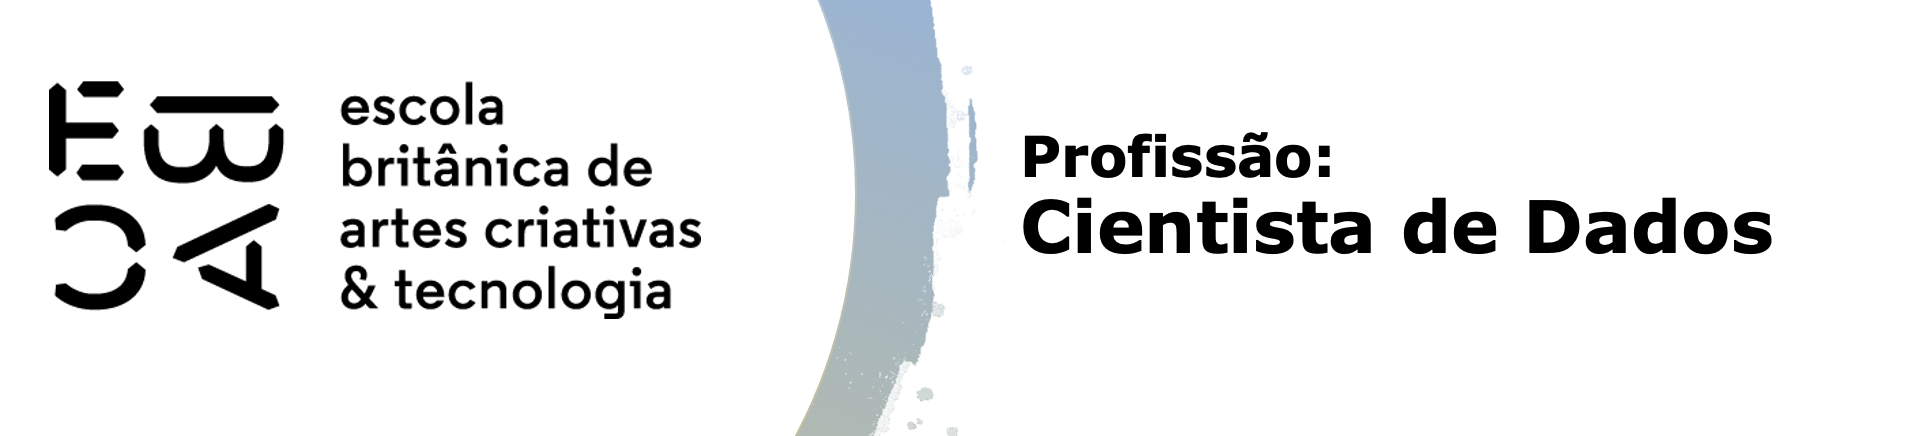

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

In [3]:
X_train = pd.read_csv(r"C:\Users\henri\OneDrive\Documentos\EBAC\X_train.csv", index_col=0)
X_train.head(1)

,subject_train,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z
order,,,,
0,1.0,0.288585,-0.020294,-0.132905


In [4]:
y_train = pd.read_csv(r"C:\Users\henri\OneDrive\Documentos\EBAC\y_train.txt", header=None)
y_train.head(1)

,0
0,5


In [5]:
X_test = pd.read_csv(r"C:\Users\henri\OneDrive\Documentos\EBAC\X_test.csv", index_col=0)
X_test.head(1)

,subject_test,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z
order,,,,
0,2.0,0.257178,-0.023285,-0.014654


In [7]:
y_test = pd.read_csv(r"C:\Users\henri\OneDrive\Documentos\EBAC\y_test.txt", header=None)
y_test.head(1)

,0
0,5


### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

In [8]:
%%time

clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=20)
path = clf.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

print("Quantidade de alphas:", len(ccp_alphas))
print("Primeiros alphas:", ccp_alphas[:10])

Quantidade de alphas: 236
Primeiros alphas: [0.00000000e+00 7.27534985e-06 1.12766571e-05 1.36017410e-05
 2.47846168e-05 2.72034820e-05 3.17115860e-05 3.58763692e-05
 3.62081190e-05 5.13108666e-05]
CPU times: total: 15.6 ms
Wall time: 69.4 ms


### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

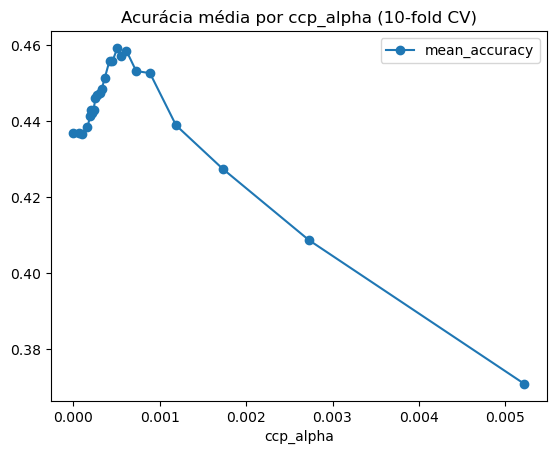

    ccp_alpha  mean_accuracy
15   0.000511       0.459193
17   0.000615       0.458377
16   0.000550       0.457017
13   0.000419       0.455796
14   0.000453       0.455657
CPU times: total: 8.39 s
Wall time: 10.2 s


In [12]:
%%time

clfs = []
alpha_values = ccp_alphas[::10]

for alpha in alpha_values:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha, min_samples_leaf=20)
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    clfs.append((alpha, scores.mean()))

results = pd.DataFrame(clfs, columns=["ccp_alpha", "mean_accuracy"])

results.plot(x="ccp_alpha", y="mean_accuracy", marker="o")
plt.title("Acurácia média por ccp_alpha (10-fold CV)")
plt.show()

print(results.sort_values("mean_accuracy", ascending=False).head())

### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

In [15]:
X_train = X_train.drop(columns=["subject_train"])
X_test  = X_test.drop(columns=["subject_test"])

Acurácia na base de teste: 0.4367153036986766


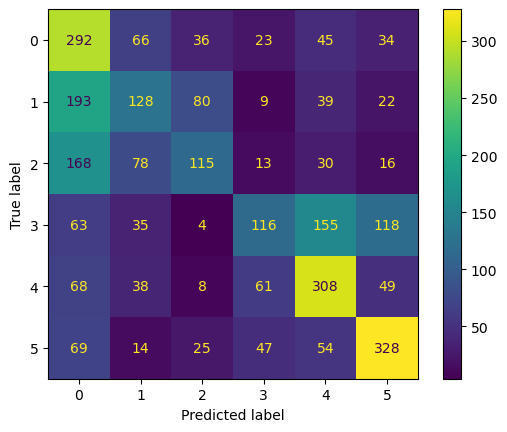

In [16]:
best_alpha = results.loc[results['mean_accuracy'].idxmax(), 'ccp_alpha']

best_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha, min_samples_leaf=20)
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)

print("Acurácia na base de teste:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

In [17]:
y_train_bin = (y_train[0] == 2).astype(int)  # transforma target em 0/1
y_test_bin  = (y_test[0] == 2).astype(int)

In [18]:
clf_simple = DecisionTreeClassifier(random_state=42, 
                                    min_samples_leaf=20, 
                                    max_depth=4)
clf_simple.fit(X_train, y_train_bin)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, random_state=42)

In [21]:
importances = pd.Series(clf_simple.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

print("Importância das variáveis:")
print(importances.head(10))

Importância das variáveis:
tBodyAcc-mean()-X    0.448604
tBodyAcc-mean()-Y    0.445014
tBodyAcc-mean()-Z    0.106382
dtype: float64


In [22]:
top3_vars = importances.head(3).index.tolist()
print("Top 3 variáveis:", top3_vars)

Top 3 variáveis: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']


Acurácia com as 3 novas variáveis: 0.4367153036986766


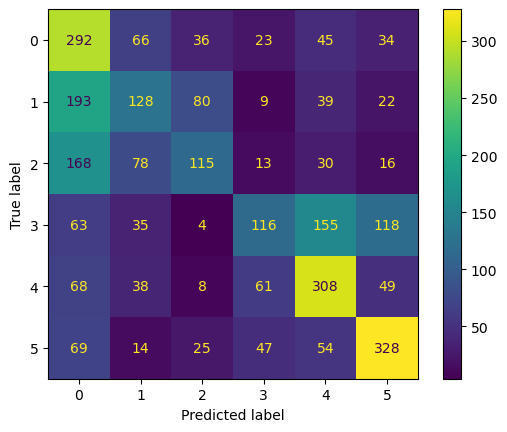

In [23]:
X_train_top3 = X_train[top3_vars]
X_test_top3  = X_test[top3_vars]

clf_final = DecisionTreeClassifier(random_state=42, 
                                   min_samples_leaf=20, 
                                   ccp_alpha=best_alpha)  # usa o melhor alpha encontrado antes
clf_final.fit(X_train_top3, y_train)

y_pred_final = clf_final.predict(X_test_top3)

print("Acurácia com as 3 novas variáveis:", accuracy_score(y_test, y_pred_final))

cm = confusion_matrix(y_test, y_pred_final)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()